In [1]:
import pandas as pd
import numpy as np
import torch
import gc
import torch.nn as nn
from tqdm import tqdm_notebook as tqdm
from torch.utils.data import Dataset, DataLoader
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import random
from sklearn import tree
from sklearn.model_selection import cross_val_score
from pymop import Problem
import os
from tslearn.datasets import UCR_UEA_datasets
import warnings
warnings.filterwarnings('ignore')

## Data

In [2]:
dataset='GunPoint'
X_train,train_y,X_test,test_y=UCR_UEA_datasets().load_dataset(dataset)
train_x=X_train.reshape(-1,X_train.shape[-1],X_train.shape[-2])
test_x=X_test.reshape(-1,X_train.shape[-1],X_train.shape[-2])

In [3]:

from models.UCRDataset import UCRDataset
from models.CNN_TSNet import CNN_TSNet
from models.CNN_TSNet import get_all_preds
from models.UCRDataset import UCRDataset
stride = 1
kernel_size=10
padding = kernel_size - 1
input_size= train_x.shape[-1]
device = torch.device( "cpu")#"cuda:0" if torch.cuda.is_available() else
model = CNN_TSNet(kernel_size=kernel_size, stride=stride, padding=padding, input_size= input_size).to(device)
model.load_state_dict(torch.load('gunpoint_best_state'))

test_dataset = UCRDataset(test_x,test_y)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=1,shuffle=True)


In [4]:
model.eval()
y_pred= model(test_x).detach().numpy()

In [5]:
observation_01, label_01 = test_dataset[0]

In [6]:
label_01=np.array([y_pred[0]])

In [7]:
labels=np.argmax(y_pred,axis=1)

In [8]:
type(np.argmax(y_pred,axis=1)[0])

numpy.int64

## MOC


In [9]:
from TSEvo.CounterfactualExplanation import Explanation
exp =Explanation(model= model,data=(test_x,np.argmax(y_pred,axis=1)), backend='PYT')

<class 'numpy.int64'>


In [10]:
pop,logbook=exp.explain_instance(observation_01,label_01,transformer = 'mutate_both')

(1, 1, 150)
Binary Case
Predict Torch


In [11]:
pop_ = [ind[0][0] for ind in pop]
print(np.array(pop).shape)

(1, 1, 150)


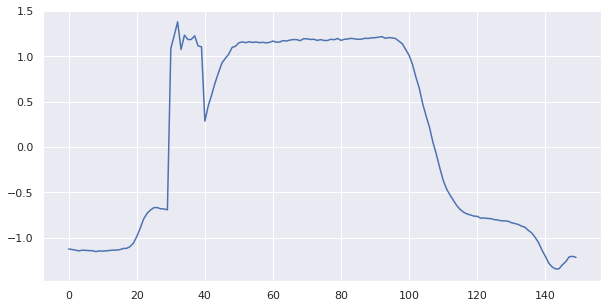

In [12]:
from evaluation.Plots import plot_CF, plot_CF_Original, plot_CF_Original_Closest
plot_CF(pop)

In [13]:
# extract statistics:
meanYDistance = logbook.chapters['stats_y_distance'].select("min")
#logbook.chapters['stats_y_distance','stats_x_distance','stats_changed_features','stats_gower'].select("avg")
meanXDistance = logbook.chapters['stats_x_distance'].select("min")
meanChanged = logbook.chapters['stats_changed_features'].select("min")

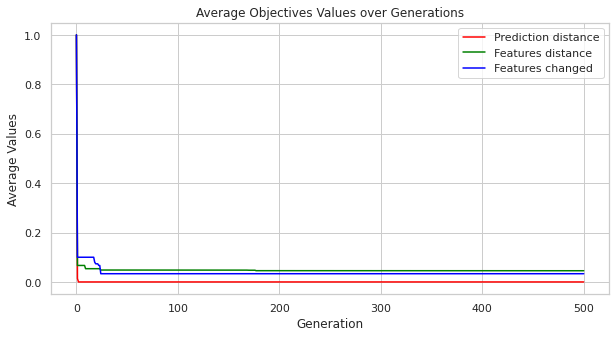

In [14]:
# plot statistics:
sns.set_style("whitegrid")
plt.plot(meanYDistance, color='red', label='Prediction distance')
plt.plot(meanXDistance, color='green', label='Features distance')
plt.plot(meanChanged, color='blue', label='Features changed')
plt.xlabel('Generation')
plt.ylabel('Average Values')
plt.title('Average Objectives Values over Generations')
plt.set_loglevel
plt.legend()
plt.show() 

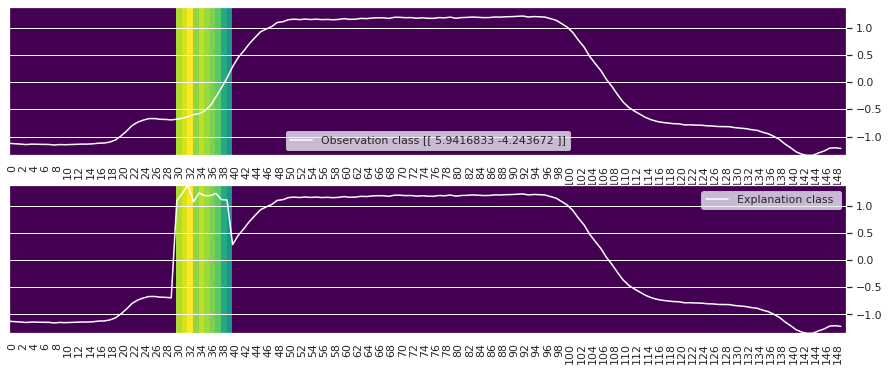

In [15]:
observation_x= observation_01
observation_y=label_01
plot_CF_Original(np.array(pop[0]), observation_x,observation_y)

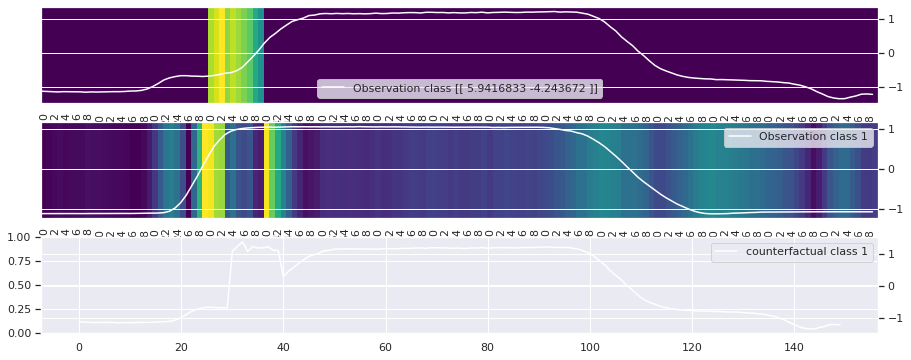

In [16]:
#TODO Rethink if original data or predicted data 
data= test_x[labels != np.argmax(label_01,axis=1)]
t=labels[labels != np.argmax(label_01,axis=1)]
timeline_max=[]
mi_max=5
i= 0
i_max=0
for timeline in data: 
    mi = np.sum(np.abs(timeline.reshape(-1)- observation_x.reshape(-1) ))/150
    if mi <mi_max: 
        mi_max=mi
        timeline_max= timeline
        i_max=i
    i = i+1
plot_CF_Original_Closest(pop,observation_x, np.argmax(observation_y[0]),timeline_max,t[i_max])

In [17]:
# Number Changes 
sal_01= np.count_nonzero(np.abs(observation_x.reshape(-1)-np.array(pop)[0][0].reshape(-1)).reshape(1,-1))
print('# Changes compared to Original', sal_01)
sal_02= np.count_nonzero(np.abs(timeline_max.reshape(-1)-np.array(pop)[0][0].reshape(-1)).reshape(1,-1))
print('# Changes compared to Closest', sal_02)



# Changes compared to Original 10
# Changes compared to Closest 150


In [18]:
from evaluation.metrics import redundancy, yNN

In [19]:
#TODO Check this out Currently max values everywhere
mlmodel = model 
counterfactuals = pop
original = observation_01 
print('YNN',yNN(counterfactuals, mlmodel,train_x,5))
print('Redundnacy',redundancy(original, counterfactuals, mlmodel))


YNN [[1.]]
Redundnacy [10]
